# Bias model bootstrapping notebook

Eventually this notebook will (hopefully?) contain all the code necessary to run our final experiments.
For now it just contains a demo of MCE IRL on some gridworlds from the "learning biases" paper.

First we have some not-very-interesting setup:

In [1]:
%matplotlib inline

# These are useful for debugging, but make code slower:
%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import jax.experimental.optimizers as jopt
import jax.random as jrandom
import numpy as np

from pref_bootstrap.envs import gridworld, mdp_interface
from pref_bootstrap.algos import mce_irl
import pref_bootstrap.feedback_learner_blind_irl as fbl_blind_irl
import pref_bootstrap.feedback_learner_paired_comparisons as fbl_paired_comp
import pref_bootstrap.reward_models as r_models
import pref_bootstrap.expert_base as experts

sns.set(context='notebook', style='darkgrid')
logging.basicConfig(level=logging.INFO)
np.set_printoptions(precision=4, linewidth=100)

## Very simple example of using environments and MCE IRL code

This code doesn't use the new agent API

In [2]:
random_gridworld = gridworld.GridworldMdp.generate_random(4, 4, 0.2, 0.1)
env = mdp_interface.GridworldEnvWrapper(random_gridworld, random_gridworld.height + random_gridworld.width)

In [3]:
# generate some optimal demos (represented by a single optimal occupancy measure vector) and run MCE IRL
_, optimal_om = mce_irl.mce_occupancy_measures(env)
rmodel = r_models.LinearRewardModel(env.obs_dim)
opt_tup = jopt.momentum(1e-2, 0.9)

In [4]:
rew_params, visitations = mce_irl.mce_irl(env, opt_tup, rmodel, optimal_om, print_interval=100, max_iter=1000)

INFO:root:Occupancy measure error@iter   0: 6.932724 (||params||=4.126315, ||grad||=9.151948, ||E[dr/dw]||=7.985312)
INFO:root:Occupancy measure error@iter  100: 0.097632 (||params||=4.994682, ||grad||=0.119587, ||E[dr/dw]||=6.148316)
INFO:root:Occupancy measure error@iter  200: 0.050535 (||params||=4.245859, ||grad||=0.063392, ||E[dr/dw]||=6.110435)
INFO:root:Occupancy measure error@iter  300: 0.019732 (||params||=3.956517, ||grad||=0.024513, ||E[dr/dw]||=6.080277)
INFO:root:Occupancy measure error@iter  400: 0.010626 (||params||=3.880323, ||grad||=0.013285, ||E[dr/dw]||=6.072812)
INFO:root:Occupancy measure error@iter  500: 0.005660 (||params||=3.857438, ||grad||=0.007306, ||E[dr/dw]||=6.071026)
INFO:root:Occupancy measure error@iter  600: 0.002983 (||params||=3.849393, ||grad||=0.003927, ||E[dr/dw]||=6.070442)
INFO:root:Occupancy measure error@iter  700: 0.001566 (||params||=3.846301, ||grad||=0.002086, ||E[dr/dw]||=6.070223)


In [5]:
print('Optimal state visitation frequencies for each grid cell:')
print(optimal_om.reshape((random_gridworld.height, random_gridworld.width)))
print('\nRecovered state visitation frequencies for each grid cell:')
print(visitations.reshape((random_gridworld.height, random_gridworld.width)))

Optimal state visitation frequencies for each grid cell:
[[0.     0.     0.     0.    ]
 [0.     1.0526 1.0649 0.    ]
 [0.     0.     5.8825 0.    ]
 [0.     0.     0.     0.    ]]

Recovered state visitation frequencies for each grid cell:
[[0.     0.     0.     0.    ]
 [0.     1.0516 1.0658 0.    ]
 [0.     0.     5.8826 0.    ]
 [0.     0.     0.     0.    ]]


## More complex example showing how to use an EnvFeedbackModel to recover both a reward function + sub-rationality model

This code actually does use the new API to show how to use the 'blind IRL' feedback model (& its associated expert, which doesn't support observation blinding yet).

In [6]:
import pref_bootstrap.feedback_learner_topk as fbl_topk

rmodel = r_models.LinearRewardModel(env.obs_dim)
top_K_feedback_model = fbl_topk.TopKFeedbackModel(env)
top_K_expert = experts.TopKExpert(env, temp=.3, K=.05, seed=42)

/userdata/smetzger/gim/lib/python3.6/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [7]:
# def genereate_top_K_dataset(n_traj): 
import random

n_traj = 1000
rmodel = r_models.LinearRewardModel(env.obs_dim)
rmodel.set_params(env.reward_matrix)
traj = mce_irl.mce_irl_sample(env, n_traj, R=np.ones((env.n_states,)))
labels= top_K_expert.interact(traj, rmodel)

labels_final, traj_final = [], []
for l, t in zip(labels, traj['states']): 

    if not(l):
        if True:#random.random() < (np.sum(labels)/len(labels)):
            labels_final.append(l), traj_final.append(t)
    else: 
        labels_final.append(l), traj_final.append(t)
        
labels_final = np.array(labels_final)
        
print(np.sum(labels)/len(labels))
print(np.sum(labels_final)/len(labels_final))


cutoff 11.23782
0.05
0.05


In [8]:
def generate_topk_dataset(n_traj):
    # def genereate_top_K_dataset(n_traj): 
    import random
    rmodel = r_models.LinearRewardModel(env.obs_dim)
    rmodel.set_params(env.reward_matrix)
    traj = mce_irl.mce_irl_sample(env, n_traj, R=np.ones((env.n_states,)))
    labels= top_K_expert.interact(traj, rmodel)

    labels_final, traj_final = [], []
    for l, t in zip(labels, traj['states']): 
        if not(l):
            if random.random() < top_K_expert.K:#TODO if there are issues update this so that we balance our dataset.
                labels_final.append(l), traj_final.append(t)
        else: 
            labels_final.append(l), traj_final.append(t)

    labels_final = np.array([int(l) for l in labels_final])
    
    return {
        'trajectories':np.array(traj_final), 
        'labels':labels_final
    }

top_K_dataset = generate_topk_dataset(1000)


cutoff 10.818285


In [9]:
lr = 1e-3
steps = 1000
loss_prev = float('Inf')
delta = 100
eps = 1e-5

import pref_bootstrap.feedback_learner_topk as fbl_topk
top_K_feedback_model = fbl_topk.TopKFeedbackModel(env)
top_K_expert = experts.TopKExpert(env, temp=.3, K=.05, seed=42)
rmodel = r_models.LinearRewardModel(env.obs_dim)
import jax
import jax.numpy as jnp

rng = jrandom.PRNGKey(23)
rng, top_K_bias_params = top_K_feedback_model.init_bias_params(rng)

top_K_bias_params.shape

/userdata/smetzger/gim/lib/python3.6/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


sampledvec [ 0.7132 -0.6194  0.4998 -0.185   0.0141  0.4348  0.3638 -0.7511 -0.5466 -0.9936 -0.3327  0.3475
  0.6076  0.0704  0.7062  0.4111 10.5754]


(17,)

In [10]:
def trad_optimize(model, data, rmodel, bias_params, use_bias_prior=False, 
                  eps=1e-9, optimize_bias=True,one_bias=False, iters=1000, lr=1e-2, printz=100):
    """
    Note: Going to add back the projected G.D
    I'm not really sure why he was trying to optimize the probability of the bias terms under the bias prior, 
    i don't really think that makes much sense. You'll basically just push it towards the mean terms even
    thought its not really there...
    
    """
    
    steps = iters
    loss_prev = float('Inf')
    delta = 100
 
    step = 0
    while(step<steps):

        grew = model.log_likelihood_grad_rew(data, rmodel, bias_params)
        new_r = rmodel.get_params() + lr*grew
        
        rmodel.set_params(new_r)
        
        gbias = model.log_likelihood_grad_bias(data, rmodel, bias_params)
       
        if use_bias_prior and optimize_bias: 
            bias_prior_grad = model.bias_prior.log_prior_grad(bias_params)
            gbias = gbias+bias_prior_grad
        if optimize_bias: 
            bias_params = bias_params+lr*gbias
        elif (not optimize_bias) and one_bias: 
            bias_params = jnp.ones_like(bias_params) # TODO: 
        
        if use_bias_prior: 
            bias_params = model.bias_prior.project_to_support(bias_params)
        
        loss = model.log_likelihood(data, rmodel, bias_params)
        if step % printz == 0:
            print('step %d loss %.3f' %(step, loss))
        if step > 0: 
            delta = loss-loss_prev
        loss_prev = loss
        step +=1

        

    if np.abs(delta) <= .0001: 
        print('terminated due to delta')
    else: 
        print('terminated due to steps exceeding %d' %steps)
        
    return model, rmodel, bias_params
rmodel = r_models.LinearRewardModel(env.obs_dim)

_, rmodel, _ = trad_optimize(top_K_feedback_model, top_K_dataset, rmodel, top_K_bias_params, optimize_bias=True, 
                            use_bias_prior=True, iters=1000)

step 0 loss -7.203
step 100 loss -0.627
step 200 loss -0.302
step 300 loss -0.236
step 400 loss -0.220
step 500 loss -0.214
step 600 loss -0.211
step 700 loss -0.208
step 800 loss -0.205
step 900 loss -0.203
terminated due to delta


Optimal state visitation frequencies for each grid cell:
[[0.     0.     0.     0.    ]
 [0.     1.0526 1.0649 0.    ]
 [0.     0.     5.8825 0.    ]
 [0.     0.     0.     0.    ]]
Inferred 
[[0.     0.     0.     0.    ]
 [0.     1.0734 1.0755 0.    ]
 [0.     0.     5.8511 0.    ]
 [0.     0.     0.     0.    ]]


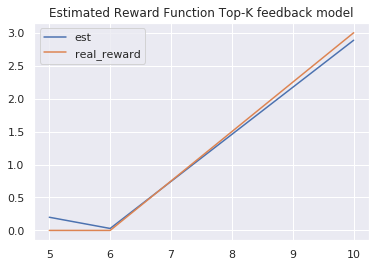

In [11]:
def evaluate(rmodel, name):


    _, topk_om = mce_irl.mce_occupancy_measures(env, R=rmodel.get_params())

    print('Optimal state visitation frequencies for each grid cell:')
    print(optimal_om.reshape((random_gridworld.height, random_gridworld.width)))

    print('Inferred ')
    print(topk_om.reshape((random_gridworld.height, random_gridworld.width)))
    
    visited_states = np.nonzero((optimal_om > 1e-5) | (topk_om > 1e-5))[0]
    plt.plot(visited_states, rmodel.get_params()[visited_states], label='est')
    plt.plot(visited_states, env.reward_matrix[visited_states], label='real_reward')
    plt.legend()
    plt.title('Estimated Reward Function %s' %name)
    plt.savefig('./images/reward_%s.png' %name)
    
evaluate(rmodel, name='Top-K feedback model')

In [12]:
pc_feedback_model = fbl_paired_comp.PairedCompFeedbackModel(env)
rng, pc_bias_params = pc_feedback_model.init_bias_params(rng)
pc_expert = experts.PairedComparisonExpert(env, boltz_temp=1.0, seed=42)

# generate some random trajectories & compare a random subset of them
def generate_comparison_dataset(pc_ntraj):
    pc_trajectories = mce_irl.mce_irl_sample(env, pc_ntraj, R=np.ones((env.n_states, )))
    to_compare_first = np.arange(len(pc_trajectories['states']))
    comparisons = []
    for first_idx in range(pc_ntraj):
        second_idx = np.random.randint(pc_ntraj - 1)
        if second_idx >= first_idx:
            second_idx += 1
        traj1_is_better = pc_expert.interact(
            dict(states=pc_trajectories['states'][first_idx]),
            dict(states=pc_trajectories['states'][second_idx]))
        if traj1_is_better:
            # the better trajectory comes before the worse one
            comparisons.append((first_idx, second_idx))
        else:
            comparisons.append((second_idx, first_idx))
    return {
        'trajectories': pc_trajectories,
        'comparisons': np.asarray(comparisons),
    }

comparison_dataset = generate_comparison_dataset(100)

/userdata/smetzger/gim/lib/python3.6/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


step 0 loss -0.428
step 100 loss -0.365
step 200 loss -0.325
step 300 loss -0.301
step 400 loss -0.291
step 500 loss -0.286
step 600 loss -0.283
step 700 loss -0.282
step 800 loss -0.282
step 900 loss -0.282
terminated due to delta
Optimal state visitation frequencies for each grid cell:
[[0.     0.     0.     0.    ]
 [0.     1.0526 1.0649 0.    ]
 [0.     0.     5.8825 0.    ]
 [0.     0.     0.     0.    ]]
Inferred 
[[0.     0.     0.     0.    ]
 [0.     1.108  1.1429 0.    ]
 [0.     0.     5.7491 0.    ]
 [0.     0.     0.     0.    ]]


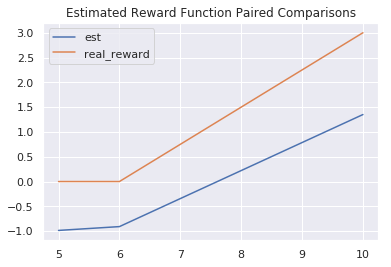

In [13]:
rmodel = r_models.LinearRewardModel(env.obs_dim)
_, rmodel, _ = trad_optimize(pc_feedback_model, comparison_dataset, rmodel, pc_bias_params, use_bias_prior=True, 
                            optimize_bias=True, one_bias=False)
evaluate(rmodel, name='Paired Comparisons')

step 0 loss -10.410
step 100 loss -9.369
step 200 loss -9.314
step 300 loss -9.286
step 400 loss -9.269
step 500 loss -9.258
step 600 loss -9.251
step 700 loss -9.246
step 800 loss -9.243
step 900 loss -9.240
terminated due to delta
Optimal state visitation frequencies for each grid cell:
[[0.     0.     0.     0.    ]
 [0.     1.0526 1.0649 0.    ]
 [0.     0.     5.8825 0.    ]
 [0.     0.     0.     0.    ]]
Inferred 
[[0.     0.     0.     0.    ]
 [0.     1.2341 1.2561 0.    ]
 [0.     0.     5.5099 0.    ]
 [0.     0.     0.     0.    ]]


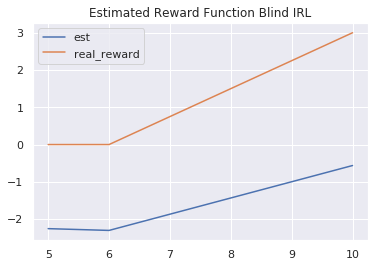

In [14]:
irl_feedback_model = fbl_blind_irl.BlindIRLFeedbackModel(env)
rmodel = r_models.LinearRewardModel(env.obs_dim)
rng = jrandom.PRNGKey(42)
rng, irl_bias_params = irl_feedback_model.init_bias_params(rng)
irl_expert = experts.MEDemonstratorExpert(env, np.random.randint((1 << 31) - 1))
# we'll do IRL based on 10 trajectories
irl_dataset = irl_expert.interact(10)
_, rmodel, _ = trad_optimize(irl_feedback_model, irl_dataset, rmodel, irl_bias_params, use_bias_prior=True, optimize_bias=True, 
                            one_bias=False)
evaluate(rmodel, name='Blind IRL')

/userdata/smetzger/gim/lib/python3.6/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/userdata/smetzger/repos/cvx_project/bootstrapping-bias-learning/pref_bootstrap/feedback_learner_scalar.py:36: RuntimeWarning: invalid value encountered in log
  ll = ((-1 * amount_of_samples)/2) * np.log(2 * np.pi) - ((-1 * amount_of_samples)/2) * np.log(bias_params[1]) - \


step 0 loss nan
step 100 loss 135.373
terminated due to steps exceeding 200
Optimal state visitation frequencies for each grid cell:
[[0.     0.     0.     0.    ]
 [0.     1.0526 1.0649 0.    ]
 [0.     0.     5.8825 0.    ]
 [0.     0.     0.     0.    ]]
Inferred 
[[0.     0.     0.     0.    ]
 [0.     1.5553 1.3484 0.    ]
 [0.     0.     5.0962 0.    ]
 [0.     0.     0.     0.    ]]


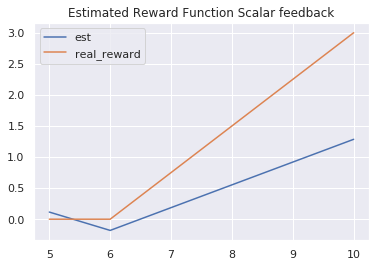

In [15]:
from pref_bootstrap import feedback_learner_scalar as fbl_scalar
s_feedback_model = fbl_scalar.ScalarFeedbackModel(env)

rng, s_feedback_params = s_feedback_model.init_bias_params(rng)
s_expert = experts.ScalarFeedbackExpert(env, seed=3)

# generate some random trajectories & compare a random subset of them
def generate_corrupted_ds(ntraj=20):
    trajectories = mce_irl.mce_irl_sample(env, ntraj, R=np.ones((env.n_states, )))
    return s_expert.interact(trajectories)
s_dataset = generate_corrupted_ds(20)
rmodel = r_models.LinearRewardModel(env.obs_dim)
_, rmodel, _ = trad_optimize(s_feedback_model, s_dataset, rmodel, s_feedback_params, use_bias_prior=False, 
                            optimize_bias=True, one_bias=False, iters=200)
evaluate(rmodel, name='Scalar feedback')

In [16]:
def multi_optimize(model_list, data_list, rmodel, bias_list, use_bias_list, optimize_reward=True, 
                   optimize_bias=True, one_bias=False): 
    
    lr = 1e-2
    steps = 1000
    loss_prev = float('Inf')
    delta = 100
    step = 0
    
    while(step<steps):
    
        grew = jnp.zeros_like(env.reward_matrix)
        
        if optimize_reward: 
            for model, data, bias_params in zip(model_list, data_list, bias_list):
                grew += model.log_likelihood_grad_rew(data, rmodel, bias_params)
        new_r = rmodel.get_params() + lr*grew
        rmodel.set_params(new_r)
        
        for k, (model, data, bias_params, use_bias_prior) in enumerate(zip(model_list, data_list, bias_list, use_bias_list)):
            gbias = model.log_likelihood_grad_bias(data, rmodel, bias_params)
            if use_bias_prior and optimize_bias: 
                bias_prior_grad = model.bias_prior.log_prior_grad(bias_params)
                gbias = gbias+bias_prior_grad
            if optimize_bias: 
                bias_params = bias_params + lr*gbias
            elif (not optimize_bias) and one_bias: 
                bias_params = jnp.ones_like(bias_params) # TODO: 
                
            if use_bias_prior: 
                bias_params = model.bias_prior.project_to_support(bias_params)
            bias_list[k] = bias_params
            
       
            
        for k, (model, data, bias_params) in enumerate(zip(model_list, data_list, bias_list)):
            loss = model.log_likelihood(data, rmodel, bias_params)
          
            if step % 100 == 0:
                print('step %d loss %.3f model %d' %(step, loss, k))
                print('---', bias_params)
        if step > 0: 
            delta = loss-loss_prev
        loss_prev = loss
        step +=1
        
    return model_list, rmodel, bias_list

In [17]:
# Reinitializing all the models

def init_models(opt_reward=False):
    irl_feedback_model = fbl_blind_irl.BlindIRLFeedbackModel(env)
    rmodel = r_models.LinearRewardModel(env.obs_dim)
    rng = jrandom.PRNGKey(42)
    rng, irl_bias_params = irl_feedback_model.init_bias_params(rng)
    irl_expert = experts.MEDemonstratorExpert(env, np.random.randint((1 << 31) - 1))
    # we'll do IRL based on 10 trajectories
    irl_dataset = irl_expert.interact(20)

    pc_feedback_model = fbl_paired_comp.PairedCompFeedbackModel(env)
    rng, pc_bias_params = pc_feedback_model.init_bias_params(rng)
    pc_expert = experts.PairedComparisonExpert(env, boltz_temp=1.0, seed=42)

    # generate some random trajectories & compare a random subset of them
    def generate_comparison_dataset(pc_ntraj):
        pc_trajectories = mce_irl.mce_irl_sample(env, pc_ntraj, R=np.ones((env.n_states, )))
        to_compare_first = np.arange(len(pc_trajectories['states']))
        comparisons = []
        for first_idx in range(pc_ntraj):
            second_idx = np.random.randint(pc_ntraj - 1)
            if second_idx >= first_idx:
                second_idx += 1
            traj1_is_better = pc_expert.interact(
                dict(states=pc_trajectories['states'][first_idx]),
                dict(states=pc_trajectories['states'][second_idx]))
            if traj1_is_better:
                # the better trajectory comes before the worse one
                comparisons.append((first_idx, second_idx))
            else:
                comparisons.append((second_idx, first_idx))
        return {
            'trajectories': pc_trajectories,
            'comparisons': np.asarray(comparisons),
        }

    comparison_dataset = generate_comparison_dataset(20)

    top_K_expert = experts.TopKExpert(env, temp=.3, K=.01, seed=42)
    def generate_topk_dataset(n_traj):
        # def genereate_top_K_dataset(n_traj): 
        import random
        rmodel = r_models.LinearRewardModel(env.obs_dim)
        rmodel.set_params(env.reward_matrix)
        traj = mce_irl.mce_irl_sample(env, n_traj, R=np.ones((env.n_states,)))
        labels= top_K_expert.interact(traj, rmodel)

        labels_final, traj_final = [], []
        for l, t in zip(labels, traj['states']): 
            if not(l):
                if random.random() < top_K_expert.K:#TODO if there are issues update this so that we balance our dataset.
                    labels_final.append(l), traj_final.append(t)
            else: 
                labels_final.append(l), traj_final.append(t)

        labels_final = np.array([int(l) for l in labels_final])

        return {
            'trajectories':np.array(traj_final), 
            'labels':labels_final
        }

    top_K_dataset = generate_topk_dataset(1000)

    import pref_bootstrap.feedback_learner_topk as fbl_topk
    top_K_feedback_model = fbl_topk.TopKFeedbackModel(env)

    rmodel = r_models.LinearRewardModel(env.obs_dim)
    import jax
    import jax.numpy as jnp

    rng = jrandom.PRNGKey(23)
    rng, top_K_bias_params = top_K_feedback_model.init_bias_params(rng)
    
    
    
    from pref_bootstrap import feedback_learner_scalar as fbl_scalar
    s_feedback_model = fbl_scalar.ScalarFeedbackModel(env)

    rng, s_feedback_params = s_feedback_model.init_bias_params(rng)
    s_expert = experts.ScalarFeedbackExpert(env, seed=3)

    # generate some random trajectories & compare a random subset of them
    def generate_corrupted_ds(ntraj=20):
        trajectories = mce_irl.mce_irl_sample(env, ntraj, R=np.ones((env.n_states, )))
        return s_expert.interact(trajectories)
    s_dataset = generate_corrupted_ds(20)
    rmodel = r_models.LinearRewardModel(env.obs_dim)
#     _, rmodel, _ = trad_optimize(s_feedback_model, s_dataset, rmodel, s_feedback_params, use_bias_prior=False, 
#                                 optimize_bias=True, one_bias=False, iters=200)
#     evaluate(rmodel, name='Scalar feedback')

    model_list = [top_K_feedback_model, pc_feedback_model, irl_feedback_model, s_feedback_model]
    data_list = [top_K_dataset, comparison_dataset, irl_dataset, s_dataset]
    bias_list = [top_K_bias_params, pc_bias_params, irl_bias_params, s_feedback_params]
    use_bias_list = [True, True, True, True]
    rmodel = r_models.LinearRewardModel(env.obs_dim)
    if opt_reward:
        rmodel.set_params(env.reward_matrix)
        
    names = ['top_K', 'paired_comparisons', 'blind_irl', 'scalar_feedback']
    
    biases_actual = []
    
    # TOP K biases 
    biases_actual.append((top_K_expert.temp, top_K_expert.cutoff))
    
    # pc actual bias
    biases_actual.append((pc_expert.boltz_temp))
    
    #blind irl actual bias
    biases_actual.append((irl_bias_params))
    
    biases_actual.append((0, 1))
        
    return model_list, data_list, rmodel, bias_list, use_bias_list, names, biases_actual

In [18]:
model_list, data_list, rmodel, bias_list, use_bias_list, names, _ = init_models(opt_reward=True)
# models, rmodel, biases = multi_optimize(model_list, data_list, rmodel, bias_list, use_bias_list, optimize_reward=False)

/userdata/smetzger/gim/lib/python3.6/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


cutoff 15.369774
sampledvec [ 0.7132 -0.6194  0.4998 -0.185   0.0141  0.4348  0.3638 -0.7511 -0.5466 -0.9936 -0.3327  0.3475
  0.6076  0.0704  0.7062  0.4111 10.5754]


Text(0.5,1,'Blind IRL')

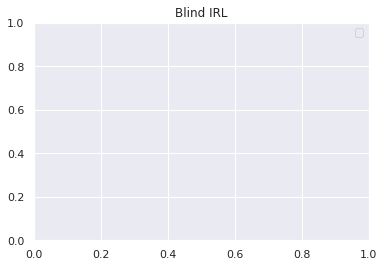

In [19]:
# plt.plot(biases[-1], label="recovered")
# plt.plot(irl_bias_params, label='Actual')
plt.legend()
plt.title('Blind IRL')

In [20]:
# Plot the distribution of rewards and labels: 
def topK_dist(top_K_dataset): 
    states = top_K_dataset['trajectories']
    flat_states = states.flatten()
    all_fn_values = rmodel.get_params() #(self.env.observation_matrix)
    rew_est = (all_fn_values[flat_states]) # hopefully jax can do this, if not...need 1-hot.
    per_obs_rew  = jnp.reshape(rew_est, states.shape[:2] + rew_est.shape[1:])
    per_traj_rew_est = jnp.sum(per_obs_rew, axis=1)
    return per_traj_rew_est

In [21]:
# Plot 1. Method comparison. 
model_list = [top_K_feedback_model, pc_feedback_model, irl_feedback_model]
data_list = [top_K_dataset, comparison_dataset, irl_dataset]
bias_list = [top_K_bias_params, pc_bias_params, irl_bias_params]
use_bias_list = [False, True, True]
rmodel = r_models.LinearRewardModel(env.obs_dim)
rmodel.set_params(env.reward_matrix)

In [22]:
import pandas as pd

def get_rew(trajs, rmodel): 
    states = trajs['states']
    flat_states = states.flatten()
    all_fn_values = rmodel
    rew_est = (all_fn_values[flat_states]) # hopefully jax can do this, if not...need 1-hot.
    per_obs_rew  = jnp.reshape(rew_est, states.shape[:2] + rew_est.shape[1:])
    per_traj_rew_est = jnp.sum(per_obs_rew, axis=1)
    return np.mean(per_traj_rew_est)

def evaluate_full(rmodel): 
    _, om = mce_irl.mce_occupancy_measures(env, R=rmodel.get_params())
    trajs = mce_irl.mce_irl_sample(env, 100, R=rmodel.get_params())
    rews = get_rew(trajs, rmodel.get_params())

    
    return rmodel.get_params(), rews, om



In [23]:
biases_recovered, biases_actual, recovered_reward, mean_reward_obtained, obs_obtained, method, fold = [],[],[],[],[],[], []



for _ in range(3): 

    # eval each method
        # reset reward_model

    model_list, data_list, rmodel, bias_list, use_bias_list, names, biases_actual = init_models()
    use_bias_list = [True, True, True, True]
    obs = [True, True, True, True]
    iterz = [1000, 1000, 1000, 200]
    for model, dataset, bias_params, ub, name, b_actual, ob, it in zip(model_list, data_list, bias_list, use_bias_list, names, biases_actual, obs, iterz):     
        rmodel = r_models.LinearRewardModel(env.obs_dim)
        _, rmodel, bias_p_recovered = trad_optimize(model, dataset, rmodel, bias_params, use_bias_prior=ub, 
                                                   optimize_bias=ob, one_bias=False, printz=10, lr=1e-3,
                                                   iters=it)

        recovered_reward_vec, mean_reward, obs_f = evaluate_full(rmodel)

        biases_recovered.append(bias_p_recovered)
        biases_actual.append(b_actual)
        recovered_reward.append(recovered_reward_vec)
        mean_reward_obtained.append(mean_reward)
        obs_obtained.append(obs_f)
        method.append(name)
        fold.append(_)
        

/userdata/smetzger/gim/lib/python3.6/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


cutoff 24.608162
sampledvec [ 0.7132 -0.6194  0.4998 -0.185   0.0141  0.4348  0.3638 -0.7511 -0.5466 -0.9936 -0.3327  0.3475
  0.6076  0.0704  0.7062  0.4111 10.5754]
step 0 loss -4.225
step 10 loss -4.107
step 20 loss -3.991
step 30 loss -3.876
step 40 loss -3.764
step 50 loss -3.653
step 60 loss -3.544
step 70 loss -3.437
step 80 loss -3.331
step 90 loss -3.227
step 100 loss -3.124
step 110 loss -3.023
step 120 loss -2.924
step 130 loss -2.825
step 140 loss -2.729
step 150 loss -2.633
step 160 loss -2.539
step 170 loss -2.447
step 180 loss -2.356
step 190 loss -2.266
step 200 loss -2.178
step 210 loss -2.091
step 220 loss -2.005
step 230 loss -1.921
step 240 loss -1.839
step 250 loss -1.758
step 260 loss -1.679
step 270 loss -1.602
step 280 loss -1.526
step 290 loss -1.452
step 300 loss -1.380
step 310 loss -1.311
step 320 loss -1.244
step 330 loss -1.179
step 340 loss -1.116
step 350 loss -1.057
step 360 loss -1.000
step 370 loss -0.946
step 380 loss -0.896
step 390 loss -0.848
step

In [25]:
rmodel.set_params(env.reward_matrix)
r, mean_rew_opt, obs_f = evaluate_full(rmodel)
obs_optimal = [obs_f]*len(method)
optimal_rew = [mean_rew_opt]*len(method)
real_rew = [r]*len(method)

res = pd.DataFrame({
    'biases_recoverd':biases_recovered,
    'recovered_reward':recovered_reward,
    'mean_reward_obtained':mean_reward_obtained,
    'obs_obtained':obs_obtained,
    'obs_optimal':obs_optimal, 
    'optimal_rew':optimal_rew, 
    'method':method
})

from datetime import datetime
now = datetime.now()
ts = now.strftime('%Y_%m_%d_%H_%M_%S')

res.to_pickle('./results/single_model_res_%s.pkl' %ts)

In [26]:
import seaborn as sns
from datetime import datetime



res = pd.read_pickle('./results/single_model_res_%s.pkl' %ts)

res

,biases_recoverd,recovered_reward,mean_reward_obtained,obs_obtained,obs_optimal,optimal_rew,method
0,"[0.012958885, -0.011254788, 0.009081519, -0.00...","[-0.74849796, -0.28937036, -0.06164298, -1.084...",8.555292,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.009690128795215, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0525768114762162, ...",19.89,top_K
1,"[0.16026074, 0.09758082, 0.1435186, 0.05051001...","[-0.15907708, -0.824764, 0.032836985, 0.211632...",-4.307773,"[0.0, 0.0, 0.0, 0.0, 0.0, 3.681741780216464, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0525768114762162, ...",19.89,paired_comparisons
2,"[1e-05, 0.99999, 0.99999, 1e-05, 1e-05, 1e-05,...","[0.5987049, -0.7029664, 0.08973532, -3.2592745...",10.433577,"[0.0, 0.0, 0.0, 0.0, 0.0, 5.67755758315425, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0525768114762162, ...",19.89,blind_irl
3,"[-0.15900321, 1.0561007]","[-1.3799312, 0.6969702, 0.07924104, -0.8336221...",6.3805637,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.4277752540488315, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0525768114762162, ...",19.89,scalar_feedback
4,"[0.012958885, -0.011254788, 0.009081519, -0.00...","[-0.12058593, -0.6695955, 0.2157848, 0.0124756...",10.367576,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.343044783913138, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0525768114762162, ...",19.89,top_K
5,"[0.16026074, 0.09758082, 0.1435186, 0.05051001...","[-1.3883016, -0.0020007812, 1.683515, 0.678960...",7.77272,"[0.0, 0.0, 0.0, 0.0, 0.0, 6.540553463884518, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0525768114762162, ...",19.89,paired_comparisons
6,"[1e-05, 0.99999, 0.99999, 1e-05, 1e-05, 0.9999...","[0.53536415, 0.2842784, 0.5953781, -0.8998707,...",-8.010259,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.7500115578761941, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0525768114762162, ...",19.89,blind_irl
7,"[0.031094605, 1.1351972]","[-0.86238086, -0.43978223, 0.9961991, -1.13320...",9.854336,"[0.0, 0.0, 0.0, 0.0, 0.0, 7.771166406634217, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0525768114762162, ...",19.89,scalar_feedback
8,"[0.012958885, -0.011254788, 0.009081519, -0.00...","[-0.75326425, -1.2300502, 0.10733298, -0.06517...",9.555393,"[0.0, 0.0, 0.0, 0.0, 0.0, 2.0106780415396472, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0525768114762162, ...",19.89,top_K
9,"[0.16026074, 0.09758082, 0.1435186, 0.05051001...","[-0.6383595, 0.9470947, 0.07902694, 0.47364736...",2.2268498,"[0.0, 0.0, 0.0, 0.0, 0.0, 5.494113999076492, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0525768114762162, ...",19.89,paired_comparisons


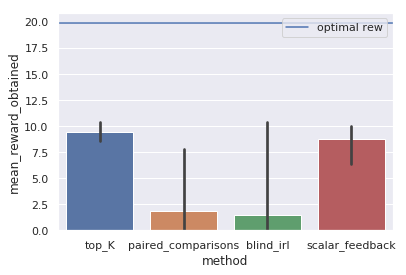

top_K
Optimal state visitation frequencies for each grid cell:
[[0.     0.     0.     0.    ]
 [0.     1.0526 1.0649 0.    ]
 [0.     0.     5.8825 0.    ]
 [0.     0.     0.     0.    ]]
Inferred 
[[0.     0.     0.     0.    ]
 [0.     4.0097 2.3648 0.    ]
 [0.     0.     1.6256 0.    ]
 [0.     0.     0.     0.    ]]
paired_comparisons
Optimal state visitation frequencies for each grid cell:
[[0.     0.     0.     0.    ]
 [0.     1.0526 1.0649 0.    ]
 [0.     0.     5.8825 0.    ]
 [0.     0.     0.     0.    ]]
Inferred 
[[0.     0.     0.     0.    ]
 [0.     3.6817 2.3744 0.    ]
 [0.     0.     1.9439 0.    ]
 [0.     0.     0.     0.    ]]
blind_irl
Optimal state visitation frequencies for each grid cell:
[[0.     0.     0.     0.    ]
 [0.     1.0526 1.0649 0.    ]
 [0.     0.     5.8825 0.    ]
 [0.     0.     0.     0.    ]]
Inferred 
[[0.     0.     0.     0.    ]
 [0.     5.6776 0.4373 0.    ]
 [0.     0.     1.8851 0.    ]
 [0.     0.     0.     0.    ]]
scalar_feedbac

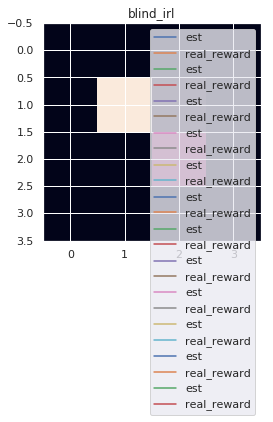

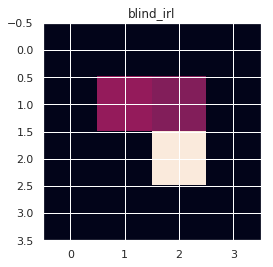

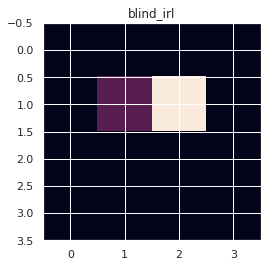

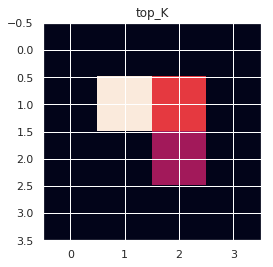

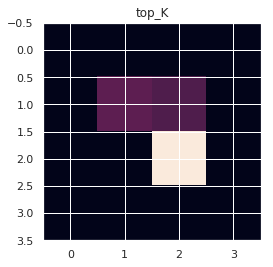

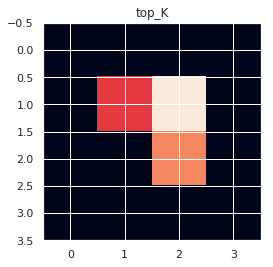

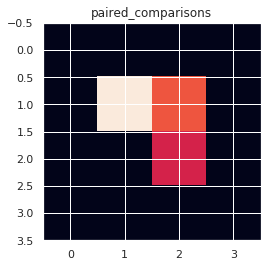

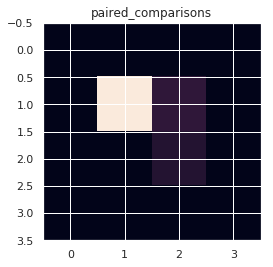

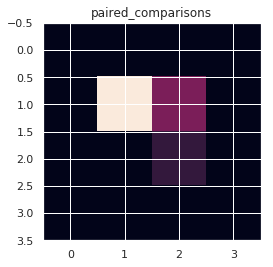

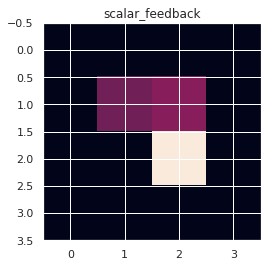

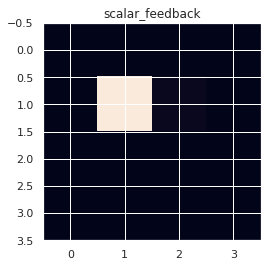

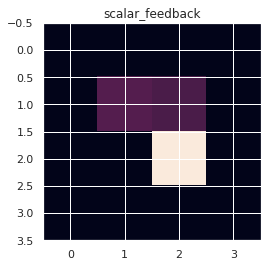

In [27]:
sns.barplot(x='method', y='mean_reward_obtained', data=res)
plt.axhline(optimal_rew[0], label='optimal rew')
plt.legend()
plt.ylim([0, optimal_rew[0]+1])
plt.savefig('./images/final-results-optimize-bias_%s.png' %ts)
plt.show()


for r, m in zip(res['recovered_reward'].values, res['method'].values): 
    print(m)
    rmodel = r_models.LinearRewardModel(env.obs_dim)
    rmodel.set_params(r)
    evaluate(rmodel, name=m)




#


for m in set(list(res['method'].values)):
    obs = res.loc[res['method']==m]['obs_obtained']
    obs = obs.values
    res_L = []
    for o in obs: 
        res_L.append(o)
        plt.imshow(o.reshape((random_gridworld.height, random_gridworld.width)))
        plt.title(m)
        plt.show()
    res_l = np.array(res_L)
    res_l = np.median(res_l, axis=0)
    

In [28]:
biases_recovered, biases_actual, recovered_reward, mean_reward_obtained, obs_obtained, method, fold = [],[],[],[],[],[], []

for _ in range(3): 

    # eval each method
        # reset reward_model

    model_list, data_list, rmodel, bias_list, use_bias_list, names, biases_actual = init_models()
    use_bias_list = [True, True, True]
    obs = [True, True, True]
    rmodel = r_models.LinearRewardModel(env.obs_dim)
    _, rmodel, bias_p_recovered = multi_optimize(model_list, data_list, rmodel, bias_list, use_bias_list,
                                               optimize_bias=True, one_bias=False)

    recovered_reward_vec, mean_reward, obs_f = evaluate_full(rmodel)

    biases_recovered.append(bias_p_recovered)
    biases_actual.append(b_actual)
    recovered_reward.append(recovered_reward_vec)
    mean_reward_obtained.append(mean_reward)
    obs_obtained.append(obs_f)
    method.append(name)
    fold.append(_)
    
print(len(biases_recovered), len(real_rew), len(recovered_reward), len(mean_reward_obtained), 
     len(obs_obtained), len(optimal_rew), len(biases_actual))

rmodel.set_params(env.reward_matrix)
r, mean_rew_opt, obs_f = evaluate_full(rmodel)
obs_optimal = [obs_f]*len(method)
optimal_rew = [mean_rew_opt]*len(method)
real_rew = [r]*len(method)

/userdata/smetzger/gim/lib/python3.6/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


cutoff 17.48214
sampledvec [ 0.7132 -0.6194  0.4998 -0.185   0.0141  0.4348  0.3638 -0.7511 -0.5466 -0.9936 -0.3327  0.3475
  0.6076  0.0704  0.7062  0.4111 10.5754]
step 0 loss -5.304 model 0
--- [ 0.6847 -0.5947  0.4798 -0.1776  0.0135  0.411   0.3432 -0.721  -0.5248 -0.9539 -0.3519  0.3336
  0.5833  0.0676  0.6779  0.3947 10.5717]
step 0 loss -0.279 model 1
--- [ 0.4315  0.2627  0.3864  0.136   0.0058 -1.3443 -0.3624  0.4627 -1.2598 -0.7345 -1.1274  0.3829
 -1.0294 -0.073   0.1084 -1.2277]
step 0 loss -11.024 model 2
--- [2.6154e-01 9.7455e-01 8.4265e-01 1.9117e-01 2.8746e-01 5.5324e-01 5.8397e-01 5.9330e-01 7.4138e-01
 2.1511e-01 3.1372e-01 9.9999e-01 2.8054e-02 8.3551e-01 9.5212e-01 1.0000e-05]
step 0 loss -400.096 model 3
--- [-0.51   1.249]
step 100 loss -0.102 model 0
--- [ 1.1551e-02 -1.0032e-02  8.0950e-03 -2.9966e-03  2.2856e-04 -3.9746e-02 -2.9758e-02 -1.2164e-02
 -8.8531e-03 -1.6092e-02 -1.6881e-01  5.6279e-03  9.8410e-03  1.1403e-03  1.1436e-02  6.6581e-03
  1.0470e+01]
s

In [29]:
res = pd.DataFrame({
    'biases_recoverd':biases_recovered,
    'recovered_reward':recovered_reward,
    'mean_reward_obtained':mean_reward_obtained,
    'obs_obtained':obs_obtained,
    'obs_optimal':obs_optimal, 
    'optimal_rew':optimal_rew, 
    'method':['combined' for m in method]
})
        

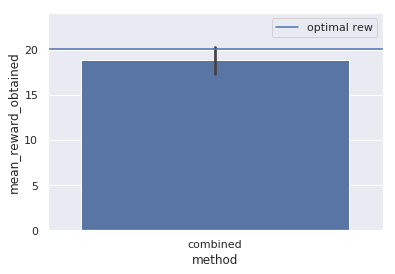

combined
combined
combined


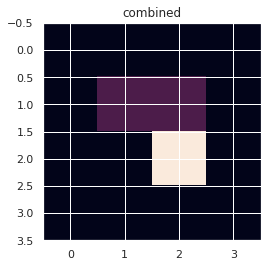

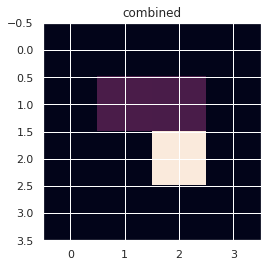

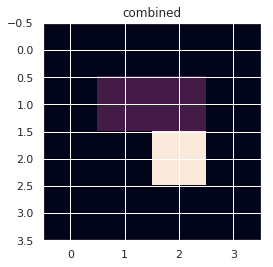

In [30]:
import seaborn as sns
from datetime import datetime

now = datetime.now()
ts = now.strftime('%Y_%m_%d_%H_%M_%S')

sns.barplot(x='method', y='mean_reward_obtained', data=res)
plt.axhline(optimal_rew[0], label='optimal rew')
plt.legend()
plt.ylim([0, optimal_rew[0]+4])
plt.savefig('./images/final-results-multi_train_%s.png' %ts)
plt.show()


for r, m in zip(res['recovered_reward'].values, res['method'].values): 
    print(m)
    
#     evaluate(r, name=m)




res.to_pickle('./results/full_multi_train_%s.pkl' %ts)

for m in set(list(res['method'].values)):
    obs = res.loc[res['method']==m]['obs_obtained']
    obs = obs.values
    res_L = []
    for o in obs: 
        res_L.append(o)
        plt.imshow(o.reshape((random_gridworld.height, random_gridworld.width)))
        plt.title(m)
        plt.show()
    res_l = np.array(res_L)
    res_l = np.median(res_l, axis=0)

In [31]:
res

,biases_recoverd,recovered_reward,mean_reward_obtained,obs_obtained,obs_optimal,optimal_rew,method
0,"[[1.3318721e-18, -1.1567285e-18, 9.333673e-19,...","[0.7713595, 0.3767606, -0.14205168, 0.9994683,...",16.930847,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.1542461238479362, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0525768114762162, ...",20.1,combined
1,"[[1.3318721e-18, -1.1567285e-18, 9.333673e-19,...","[-0.3603995, -0.48750865, 1.0751077, 1.1371439...",18.247639,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.1381871872912468, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0525768114762162, ...",20.1,combined
2,"[[1.3318721e-18, -1.1567285e-18, 9.333673e-19,...","[-0.33279315, -0.5484882, 0.88175154, -1.40479...",21.359167,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0659853669618382, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0525768114762162, ...",20.1,combined


In [32]:
# compare shared bias  params vs the other ones

In [95]:
df_single = pd.read_pickle('/userdata/smetzger/repos/cvx_project/bootstrapping-bias-learning/results/single_model_res_2020_12_16_09_49_03.pkl')

df_single = pd.read_pickle('/userdata/smetzger/repos/cvx_project/bootstrapping-bias-learning/results/single_model_res_2020_12_16_10_54_52.pkl')

In [96]:
df_shared = pd.read_pickle('/userdata/smetzger/repos/cvx_project/bootstrapping-bias-learning/results/full_multi_train_2020_12_16_11_14_54.pkl')
# df_shared = pd.read_pickle('/userdata/smetzger/repos/cvx_project/bootstrapping-bias-learning/results/full_multi_train_2020_12_16_10_10_16.pkl')
#pd.read_pickle('/userdata/smetzger/repos/cvx_project/bootstrapping-bias-learning/results/full_multi_train_2020_12_07_13_57_28.pkl')

In [97]:
res = pd.read_pickle('/userdata/smetzger/repos/cvx_project/bootstrapping-bias-learning/results/scalar_feedback_res_2020_12_07_23_13_09.pkl')

In [98]:
endv_single = df_single['biases_recoverd'].values

In [99]:
endv_shared = []
g = df_shared['biases_recoverd'].values
for gg in g:
    endv_shared.extend(gg)

In [100]:
endv_shared

[array([ 1.3319e-18, -1.1567e-18,  9.3337e-19, -3.4551e-19,  2.6354e-20,  5.6429e-03,  2.1028e-02,
        -1.4025e-18, -1.0208e-18, -1.8555e-18,  2.7389e-02,  6.4891e-19,  1.1347e-18,  1.3149e-19,
         1.3187e-18,  7.6769e-19,  1.1596e+01], dtype=float32),
 array([ 1.8816e-05,  1.1457e-05,  1.6851e-05,  5.9304e-06,  2.5429e-07, -6.0804e-02,  5.0479e-02,
         2.0179e-05, -5.4935e-05, -3.2029e-05,  1.0202e-02,  1.6698e-05, -4.4890e-05, -3.1823e-06,
         4.7275e-06, -5.3537e-05], dtype=float32),
 array([1.0000e-05, 9.9999e-01, 9.9999e-01, 1.0000e-05, 1.0000e-05, 9.9999e-01, 9.9999e-01,
        9.9999e-01, 9.9999e-01, 1.0000e-05, 9.9999e-01, 9.9999e-01, 1.0000e-05, 9.9999e-01,
        9.9999e-01, 1.0000e-05], dtype=float32),
 array([-0.51 ,  1.249], dtype=float32),
 array([ 1.3319e-18, -1.1567e-18,  9.3337e-19, -3.4551e-19,  2.6354e-20,  1.5508e-02,  6.0414e-03,
        -1.4025e-18, -1.0208e-18, -1.8555e-18,  6.2729e-03,  6.4891e-19,  1.1347e-18,  1.3149e-19,
         1.3187e-

In [101]:
endv_shared

[array([ 1.3319e-18, -1.1567e-18,  9.3337e-19, -3.4551e-19,  2.6354e-20,  5.6429e-03,  2.1028e-02,
        -1.4025e-18, -1.0208e-18, -1.8555e-18,  2.7389e-02,  6.4891e-19,  1.1347e-18,  1.3149e-19,
         1.3187e-18,  7.6769e-19,  1.1596e+01], dtype=float32),
 array([ 1.8816e-05,  1.1457e-05,  1.6851e-05,  5.9304e-06,  2.5429e-07, -6.0804e-02,  5.0479e-02,
         2.0179e-05, -5.4935e-05, -3.2029e-05,  1.0202e-02,  1.6698e-05, -4.4890e-05, -3.1823e-06,
         4.7275e-06, -5.3537e-05], dtype=float32),
 array([1.0000e-05, 9.9999e-01, 9.9999e-01, 1.0000e-05, 1.0000e-05, 9.9999e-01, 9.9999e-01,
        9.9999e-01, 9.9999e-01, 1.0000e-05, 9.9999e-01, 9.9999e-01, 1.0000e-05, 9.9999e-01,
        9.9999e-01, 1.0000e-05], dtype=float32),
 array([-0.51 ,  1.249], dtype=float32),
 array([ 1.3319e-18, -1.1567e-18,  9.3337e-19, -3.4551e-19,  2.6354e-20,  1.5508e-02,  6.0414e-03,
        -1.4025e-18, -1.0208e-18, -1.8555e-18,  6.2729e-03,  6.4891e-19,  1.1347e-18,  1.3149e-19,
         1.3187e-

In [102]:
endv_single

array([array([ 1.2959e-02, -1.1255e-02,  9.0815e-03, -3.3618e-03,  2.5642e-04,  3.0733e-02,  2.0147e-02,
       -1.3647e-02, -9.9321e-03, -1.8054e-02, -2.6313e-01,  6.3138e-03,  1.1040e-02,  1.2793e-03,
        1.2830e-02,  7.4695e-03,  1.0494e+01], dtype=float32),
       array([ 0.1603,  0.0976,  0.1435,  0.0505,  0.0022, -0.5879, -0.2704,  0.1719, -0.4679, -0.2728,
       -0.1943,  0.1422, -0.3823, -0.0271,  0.0403, -0.456 ], dtype=float32),
       array([1.0000e-05, 9.9999e-01, 9.9999e-01, 1.0000e-05, 1.0000e-05, 1.0000e-05, 9.9999e-01,
       9.9999e-01, 9.9999e-01, 1.0000e-05, 9.9999e-01, 9.9999e-01, 1.0000e-05, 9.9999e-01,
       9.9999e-01, 1.0000e-05], dtype=float32),
       array([-0.159 ,  1.0561], dtype=float32),
       array([ 1.2959e-02, -1.1255e-02,  9.0815e-03, -3.3618e-03,  2.5642e-04, -7.5225e-02, -6.0161e-02,
       -1.3647e-02, -9.9321e-03, -1.8054e-02, -2.5847e-01,  6.3138e-03,  1.1040e-02,  1.2793e-03,
        1.2830e-02,  7.4695e-03,  1.0363e+01], dtype=float32),


(16,)
(3, 17) (17,)
(3,)
[11.8367 11.8713 11.7646]


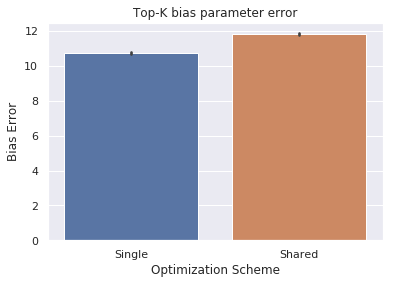

In [103]:
shares = np.array(endv_shared[::4])

b = top_K_expert.bias
print(b.shape)
b = list(np.array(b))
actual = np.array(b + [top_K_expert.cutoff])
print(shares.shape, actual.shape)
b_err_shared = np.linalg.norm(shares-np.array(actual), axis=-1)
print(b_err_shared.shape)
endv_single[::4]
singles = endv_single[::4]
singles = np.array([s for s in singles])


b_err_single = np.linalg.norm(singles-np.array(actual), axis=-1)
print(np.linalg.norm(shares-np.array(actual), axis=-1))
sns.barplot(x='Optimization Scheme', y='Bias Error', data = pd.DataFrame({'Optimization Scheme':['Single']*3 + ['Shared']*3,
                                                                         'Bias Error': np.concatenate((b_err_single, b_err_shared), axis=0)
                                                                        }))
plt.title('Top-K bias parameter error')
plt.savefig('./images/shared_bias_params_topK')

[4.5733 4.5809 4.5712] [4.0008 4.0005 4.0002]


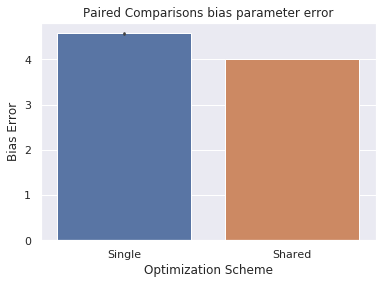

In [104]:
shares = np.array(endv_shared[1::4])

actual = (1.0)
b_err_shared = np.linalg.norm(np.array(shares)-np.array(actual), axis=-1)
endv_single[1::4]
singles = endv_single[1::4]
singles = np.array([s for s in singles])

b_err_single = np.linalg.norm(singles-np.array(actual), axis=-1)
print(b_err_single, b_err_shared)
sns.barplot(x='Optimization Scheme', y='Bias Error', data = pd.DataFrame({'Optimization Scheme':['Single']*3 + ['Shared']*3,
                                                                         'Bias Error': np.concatenate((b_err_single,
                                                                                                       b_err_shared), axis=0)
                                                                        }))
plt.title('Paired Comparisons bias parameter error')
plt.savefig('./images/shared_bias_params_topK')

[1.1604 0.9783 1.1233] [1.5303 1.5303 1.5303]


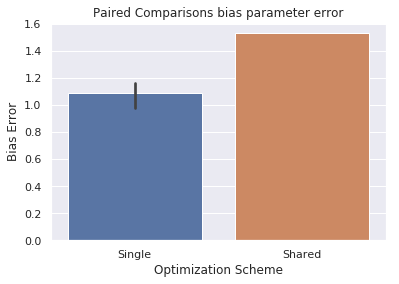

In [105]:
shares = np.array(endv_shared[3::4])

actual = (1.0)
b_err_shared = np.linalg.norm(np.array(shares)-np.array(actual), axis=-1)
endv_single[3::4]
singles = endv_single[3::4]
singles = np.array([s for s in singles])

b_err_single = np.linalg.norm(singles-np.array(actual), axis=-1)
print(b_err_single, b_err_shared)
sns.barplot(x='Optimization Scheme', y='Bias Error', data = pd.DataFrame({'Optimization Scheme':['Single']*3 + ['Shared']*3,
                                                                         'Bias Error': np.concatenate((b_err_single,
                                                                                                       b_err_shared), axis=0)
                                                                        }))
plt.title('Paired Comparisons bias parameter error')
plt.savefig('./images/shared_bias_params_scaled')

INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


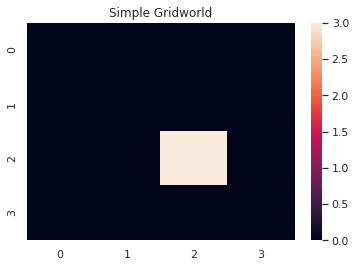

In [43]:
sns.heatmap(env.reward_matrix.reshape(4, 4))
plt.title('Simple Gridworld')
plt.savefig('./images/simple_gridworld')

In [44]:
df_single
df_single = df_single.append(res)


In [45]:
df_single['inf norm, visitation'] = df_single['obs_obtained'] - df_single['obs_optimal']

In [46]:
df_single['inf norm, visitation'] = df_single['inf norm, visitation'].apply(lambda x: np.linalg.norm(np.array(x), ord=np.inf))

In [47]:
df_single

,biases_recoverd,recovered_reward,mean_reward_obtained,obs_obtained,obs_optimal,optimal_rew,method,"inf norm, visitation"
0,"[0.012958885, -0.011254788, 0.009081519, -0.00...","[-0.62024176, 0.16649608, 0.80572677, -0.01611...",9.774688,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1827759448530...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003556744056...",23.19,top_K,1.043077
1,"[0.16026074, 0.09758082, 0.1435186, 0.05051001...","[-1.2635443, 0.44963515, 1.250251, 0.015750198...",5.6821456,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0482812892042...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003556744056...",23.19,paired_comparisons,6.474361
2,"[1e-05, 0.99999, 0.99999, 1e-05, 1e-05, 0.9999...","[-0.84743273, -1.9866761, -0.7064143, 0.563660...",-9.535393,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.9414359434623...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003556744056...",23.19,blind_irl,3.235822
3,"[0.3619805, 1.2576808]","[-0.78704053, 0.25178394, 0.046854924, -0.2238...",-2.571131,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1114602533037...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003556744056...",23.19,scalar_feedback,0.787336
4,"[0.012958885, -0.011254788, 0.009081519, -0.00...","[-1.560282, -0.044252407, -0.016756902, 0.1551...",9.106501,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1512375514028...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003556744056...",23.19,top_K,3.701958
5,"[0.16026074, 0.09758082, 0.1435186, 0.05051001...","[-1.3268962, 1.9076751, -1.7943662, 1.3043101,...",1.6321622,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4924261448694...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003556744056...",23.19,paired_comparisons,2.547827
6,"[1e-05, 0.99999, 0.99999, 1e-05, 1e-05, 0.9999...","[-0.67089224, 0.3485008, 0.62747276, -0.389718...",13.953064,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0278727762783...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003556744056...",23.19,blind_irl,1.277865
7,"[-0.03750392, 1.1078548]","[0.21180807, 1.376979, 0.010444359, -0.5565442...",11.828794,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.8269298408904...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003556744056...",23.19,scalar_feedback,5.786451
8,"[0.012958885, -0.011254788, 0.009081519, -0.00...","[0.18117955, -0.3685908, 0.6554242, -0.3175438...",8.907564,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7501917727550...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003556744056...",23.19,top_K,3.335665
9,"[0.16026074, 0.09758082, 0.1435186, 0.05051001...","[1.2744261, -1.7968236, -0.27932718, -2.525017...",9.27183,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0083773722764...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003556744056...",23.19,paired_comparisons,0.297352


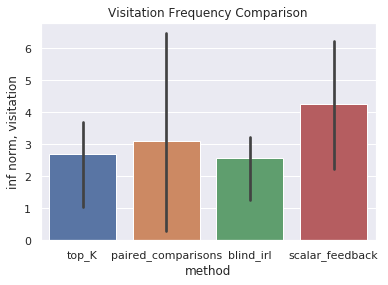

In [48]:
sns.barplot(x='method', y='inf norm, visitation', data = df_single)
plt.title('Visitation Frequency Comparison')
plt.savefig('./images/visitation_freq')

In [49]:
df_shared['inf norm, visitation'] = df_shared['obs_obtained'] - df_shared['obs_optimal']
df_shared['inf norm, visitation'] = df_shared['inf norm, visitation'].apply(lambda x: np.linalg.norm(x, ord=np.inf))

In [50]:
df_shared.head()

,biases_recoverd,recovered_reward,mean_reward_obtained,obs_obtained,obs_optimal,optimal_rew,method,"inf norm, visitation"
0,"[[1.3318721e-18, -1.1567285e-18, 9.333673e-19,...","[-0.48733196, 1.6436743, -0.81741416, 0.360517...",17.617544,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0017514956414...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003556744056...",23.22,combined,0.071429
1,"[[1.3318721e-18, -1.1567285e-18, 9.333673e-19,...","[-0.75874716, 1.706731, 0.53312063, 0.52418447...",21.994413,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0007718602097...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003556744056...",23.22,combined,0.025880
2,"[[1.3318721e-18, -1.1567285e-18, 9.333673e-19,...","[-0.024439976, 1.1342909, -0.6199166, -1.56792...",18.861593,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0021200994295...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003556744056...",23.22,combined,0.076377


In [51]:


df_combo = df_single.append(df_shared)

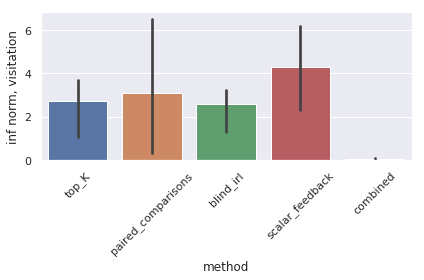

In [52]:
sns.barplot(x='method', y='inf norm, visitation', data = df_combo)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./images/vistation_results.png')

array([ 0.0491,  0.3116,  0.3499,  0.0937, -0.8028,  0.7486,  0.9737,  0.0409,  0.734 , -0.8086,
        0.1945, -0.0569, -0.342 , -0.5665, -0.9911,  0.8099])

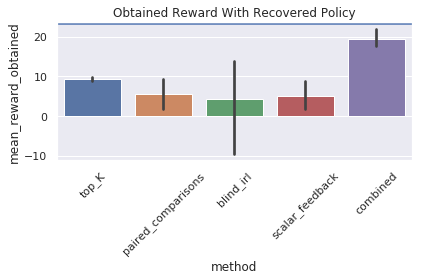

In [53]:
sns.barplot(x='method', y='mean_reward_obtained', data=df_combo)
plt.axhline(df_combo['optimal_rew'].values[0], label='MCE IRL mean r')
plt.xticks(rotation=45)
plt.title('Obtained Reward With Recovered Policy')
plt.tight_layout()
plt.savefig('./images/reward_results.png')

In [ ]:
df_combo

In [ ]:
plt.figure(figsize=(15, 3))
for k in range(3):
    plt.subplot(150+k+1)
    plt.imshow(df_single['obs_obtained'].values[k+6].reshape(4, 4))
    plt.title(['Top K', 'Paired Comparisons', 'Blind IRL'][k])
    if k == 0: 
        plt.xlabel('State X')
        plt.ylabel('State Y')
plt.subplot(150+4)
plt.imshow(df_single['obs_obtained'].values[-2].reshape(4, 4))
plt.title('Scalar Feedback')
if k == 0: 
    plt.xlabel('State X')
    plt.ylabel('State Y')
plt.subplot(155)
plt.imshow(df_single['obs_optimal'].values[3].reshape(4, 4))
plt.title('Optimal (MCE IRL)')
plt.savefig('./images/vistation_example')

In [ ]:
plt.imshow(df_single['obs_optimal'].values[3].reshape(4, 4))

In [ ]:
df_single